Assignment 2 - Big Data with H2O

**Binary Classification**

In [7]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool

Set up some parameters for the analysis.  

In [8]:
data_path=None
all_variables=None
test_path=None
target=None
nthreads=1 
min_mem_size=6 
run_time=333
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0 

The next sections contains helper functions for automating analysis.             

In [9]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(run_id,analysis,target,run_time,classification,scale,model,balance,balance_threshold,name,nthreads,min_mem_size):
  m_data={}
  m_data['run_id'] =run_id
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [10]:
data_path='C:/Fall 2018 semester/Big Data Systems Intelligence and Analytics/BDIA Assignment 1/Kicks_df.csv'

In [11]:
data_path = os.path.join(os.path.abspath(os.curdir),data_path)

In [12]:
all_variables=None

In [13]:
run_id=alphabet(9)
# run_id to std out
print (run_id) 

KjPEFmec0


In [14]:
server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir) 

In [15]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:7291..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from C:\Users\Leo\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Leo\AppData\Local\Temp\tmp70zfnbo2
  JVM stdout: C:\Users\Leo\AppData\Local\Temp\tmp70zfnbo2\h2o_Leo_started_from_python.out
  JVM stderr: C:\Users\Leo\AppData\Local\Temp\tmp70zfnbo2\h2o_Leo_started_from_python.err
  Server is running at http://127.0.0.1:7291
Connecting to H2O server at http://127.0.0.1:7291..... successful.


H2O cluster uptime:,37 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,1 month and 9 days
H2O cluster name:,H2O_from_python_Leo_96pej5
H2O cluster total nodes:,1
H2O cluster free memory:,5.750 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"


In [10]:
# meta data
meta_data = set_meta_data(run_id,analysis,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,nthreads,min_mem_size)
print(meta_data)  

{'run_id': 'qsp7ujPXX', 'start_time': 1540957227.338017, 'target': None, 'max_models': 9, 'run_time': 333, 'scale': False, 'classification': False, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1540957227.338017, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [11]:
print(data_path)

C:/Fall 2018 semester/Big Data Systems Intelligence and Analytics/BDIA Assignment 1/Kicks_df.csv


In [12]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
df.head()

C1,goal,backers,country_is_us,Goal_1000,Goal_500,Goal_10,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Crafts,category_Crochet,category_DIY,category_DIY Electronics,category_Dance,category_Design,category_Digital Art,category_Documentary,category_Drama,category_Drinks,category_Electronic Music,category_Embroidery,category_Events,category_Experimental,category_Fabrication Tools,category_Faith,category_Family,category_Fantasy,category_Farmer's Markets,category_Farms,category_Fashion,category_Festivals,category_Fiction,category_Film & Video,category_Fine Art,category_Flight,category_Food,category_Food Trucks,category_Footwear,category_Gadgets,category_Games,category_Gaming Hardware,category_Glass,category_Graphic Design,category_Graphic Novels,category_Hardware,category_Hip-Hop,category_Horror,category_Illustration,category_Immersive,category_Indie Rock,category_Installations,category_Interactive Design,category_Jazz,category_Jewelry,category_Journalism,category_Kids,category_Knitting,category_Latin,category_Letterpress,category_Literary Journals,category_Live Games,category_Makerspaces,category_Metal,category_Mixed Media,category_Mobile Games,category_Movie Theaters,category_Music,category_Music Videos,category_Musical,category_Narrative Film,category_Nature,category_Nonfiction,category_Painting,category_People,category_Performance Art,category_Performances,category_Periodicals,category_Pet Fashion,category_Photo,category_Photobooks,category_Photography,category_Places,category_Playing Cards,category_Plays,category_Poetry,category_Pop,category_Pottery,category_Print,category_Printing,category_Product Design,category_Public Art,category_Publishing,category_Punk,category_Puzzles,category_R&B,category_Radio & Podcasts,category_Ready-to-wear,category_Restaurants,category_Robots,category_Rock,category_Romance,category_Science Fiction,category_Sculpture,category_Shorts,category_Small Batch,category_Software,category_Sound,category_Space Exploration,category_Spaces,category_Stationery,category_Tabletop Games,category_Technology,category_Television,category_Textiles,category_Theater,category_Thrillers,category_Translations,category_Typography,category_Vegan,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,state
4073,8.41205,4,1,4,9,450,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
267,9.21044,65,1,10,20,1000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4803,8

In [14]:
df.describe()

Rows:4409
Cols:174




,C1,goal,backers,country_is_us,Goal_1000,Goal_500,Goal_10,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Crafts,category_Crochet,category_DIY,category_DIY Electronics,category_Dance,category_Design,category_Digital Art,category_Documentary,category_Drama,category_Drinks,category_Electronic Music,category_Embroidery,category_Events,category_Experimental,category_Fabrication Tools,category_Faith,category_Family,category_Fantasy,category_Farmer's Markets,category_Farms,category_Fashion,category_Festivals,category_Fiction,category_Film & Video,category_Fine Art,category_Flight,category_Food,category_Food Trucks,category_Footwear,category_Gadgets,category_Games,category_Gaming Hardware,category_Glass,category_Graphic Design,category_Graphic Novels,category_Hardware,category_Hip-Hop,category_Horror,category_Illustration,category_Immersive,category_Indie Rock,category_Installations,category_Interactive Design,category_Jazz,category_Jewelry,category_Journalism,category_Kids,category_Knitting,category_Latin,category_Letterpress,category_Literary Journals,category_Live Games,category_Makerspaces,category_Metal,category_Mixed Media,category_Mobile Games,category_Movie Theaters,category_Music,category_Music Videos,category_Musical,category_Narrative Film,category_Nature,category_Nonfiction,category_Painting,category_People,category_Performance Art,category_Performances,category_Periodicals,category_Pet Fashion,category_Photo,category_Photobooks,category_Photography,category_Places,category_Playing Cards,category_Plays,category_Poetry,category_Pop,category_Pottery,category_Print,category_Printing,category_Product Design,category_Public Art,category_Publishing,category_Punk,category_Puzzles,category_R&B,category_Radio & Podcasts,category_Ready-to-wear,category_Restaurants,category_Robots,category_Rock,category_Romance,category_Science Fiction,category_Sculpture,category_Shorts,category_Small Batch,category_Software,category_Sound,category_Space Exploration,category_Spaces,category_Stationery,category_Tabletop Games,category_Technology,category_Television,category_Textiles,category_Theater,category_Thrillers,category_Translations,category_Typography,category_Vegan,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,state
type,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,0.0,0.6471032420585

describe()[source]
Generate an in-depth description of this H2OFrame.

The description is a tabular print of the type, min, max, sigma, number of zeros, and number of missing elements for each H2OVec in this H2OFrame.

Returns:	None (print to stdout) 

In [15]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
  target=df.columns[-1]   
y = target

In [16]:
print(y)

state


In [17]:
print(all_variables)

None


In [18]:
if all_variables is not None:
  ivd=get_all_variables_csv(all_variables)
  print(ivd)    
  X=check_all_variables(df,ivd,y)
  print(X)

In [19]:
df.describe()

Rows:4409
Cols:174




,C1,goal,backers,country_is_us,Goal_1000,Goal_500,Goal_10,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Crafts,category_Crochet,category_DIY,category_DIY Electronics,category_Dance,category_Design,category_Digital Art,category_Documentary,category_Drama,category_Drinks,category_Electronic Music,category_Embroidery,category_Events,category_Experimental,category_Fabrication Tools,category_Faith,category_Family,category_Fantasy,category_Farmer's Markets,category_Farms,category_Fashion,category_Festivals,category_Fiction,category_Film & Video,category_Fine Art,category_Flight,category_Food,category_Food Trucks,category_Footwear,category_Gadgets,category_Games,category_Gaming Hardware,category_Glass,category_Graphic Design,category_Graphic Novels,category_Hardware,category_Hip-Hop,category_Horror,category_Illustration,category_Immersive,category_Indie Rock,category_Installations,category_Interactive Design,category_Jazz,category_Jewelry,category_Journalism,category_Kids,category_Knitting,category_Latin,category_Letterpress,category_Literary Journals,category_Live Games,category_Makerspaces,category_Metal,category_Mixed Media,category_Mobile Games,category_Movie Theaters,category_Music,category_Music Videos,category_Musical,category_Narrative Film,category_Nature,category_Nonfiction,category_Painting,category_People,category_Performance Art,category_Performances,category_Periodicals,category_Pet Fashion,category_Photo,category_Photobooks,category_Photography,category_Places,category_Playing Cards,category_Plays,category_Poetry,category_Pop,category_Pottery,category_Print,category_Printing,category_Product Design,category_Public Art,category_Publishing,category_Punk,category_Puzzles,category_R&B,category_Radio & Podcasts,category_Ready-to-wear,category_Restaurants,category_Robots,category_Rock,category_Romance,category_Science Fiction,category_Sculpture,category_Shorts,category_Small Batch,category_Software,category_Sound,category_Space Exploration,category_Spaces,category_Stationery,category_Tabletop Games,category_Technology,category_Television,category_Textiles,category_Theater,category_Thrillers,category_Translations,category_Typography,category_Vegan,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,state
type,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,0.0,0.6471032420585

In [20]:
# independent variables

X = []  
if all_variables is None:
  X=get_independent_variables(df, target)  
else: 
  ivd=get_all_variables_csv(all_variables)    
  X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

In [21]:
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True

In [22]:
print(classification)

False


In [23]:
# Force target to be factors
# Only 'int' or 'string' are allowed for asfactor(), got Target (Total orders):real 

if classification:
    df[y] = df[y].asfactor()

In [24]:
def check_y(y,df):
  ok=False
  C = [name for name in df.columns if name == y]
  for key, val in df.types.items():
    if key in C:
      if val in ['real','int','enum']:        
        ok=True         
  return ok, val   

In [25]:
ok,val=check_y(y,df)

In [26]:
print(val)

int


In [27]:
print(ok)

True


In [28]:
if val=='enum':
    print(df[y].levels())

In [29]:
df.describe()

Rows:4409
Cols:174




,C1,goal,backers,country_is_us,Goal_1000,Goal_500,Goal_10,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,category_Art,category_Art Books,category_Audio,category_Bacon,category_Blues,category_Calendars,category_Camera Equipment,category_Candles,category_Ceramics,category_Children's Books,category_Childrenswear,category_Civic Design,category_Classical Music,category_Comedy,category_Comic Books,category_Comics,category_Community Gardens,category_Conceptual Art,category_Cookbooks,category_Country & Folk,category_Crafts,category_Crochet,category_DIY,category_DIY Electronics,category_Dance,category_Design,category_Digital Art,category_Documentary,category_Drama,category_Drinks,category_Electronic Music,category_Embroidery,category_Events,category_Experimental,category_Fabrication Tools,category_Faith,category_Family,category_Fantasy,category_Farmer's Markets,category_Farms,category_Fashion,category_Festivals,category_Fiction,category_Film & Video,category_Fine Art,category_Flight,category_Food,category_Food Trucks,category_Footwear,category_Gadgets,category_Games,category_Gaming Hardware,category_Glass,category_Graphic Design,category_Graphic Novels,category_Hardware,category_Hip-Hop,category_Horror,category_Illustration,category_Immersive,category_Indie Rock,category_Installations,category_Interactive Design,category_Jazz,category_Jewelry,category_Journalism,category_Kids,category_Knitting,category_Latin,category_Letterpress,category_Literary Journals,category_Live Games,category_Makerspaces,category_Metal,category_Mixed Media,category_Mobile Games,category_Movie Theaters,category_Music,category_Music Videos,category_Musical,category_Narrative Film,category_Nature,category_Nonfiction,category_Painting,category_People,category_Performance Art,category_Performances,category_Periodicals,category_Pet Fashion,category_Photo,category_Photobooks,category_Photography,category_Places,category_Playing Cards,category_Plays,category_Poetry,category_Pop,category_Pottery,category_Print,category_Printing,category_Product Design,category_Public Art,category_Publishing,category_Punk,category_Puzzles,category_R&B,category_Radio & Podcasts,category_Ready-to-wear,category_Restaurants,category_Robots,category_Rock,category_Romance,category_Science Fiction,category_Sculpture,category_Shorts,category_Small Batch,category_Software,category_Sound,category_Space Exploration,category_Spaces,category_Stationery,category_Tabletop Games,category_Technology,category_Television,category_Textiles,category_Theater,category_Thrillers,category_Translations,category_Typography,category_Vegan,category_Video,category_Video Art,category_Video Games,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines,state
type,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,0.0,0.6471032420585

In [30]:
allV=get_variables_types(df)
allV

{'C1': 'int',
 'Goal_10': 'int',
 'Goal_1000': 'int',
 'Goal_500': 'int',
 'backers': 'int',
 'category_Academic': 'int',
 'category_Accessories': 'int',
 'category_Action': 'int',
 'category_Animals': 'int',
 'category_Animation': 'int',
 'category_Anthologies': 'int',
 'category_Apparel': 'int',
 'category_Apps': 'int',
 'category_Architecture': 'int',
 'category_Art': 'int',
 'category_Art Books': 'int',
 'category_Audio': 'int',
 'category_Bacon': 'int',
 'category_Blues': 'int',
 'category_Calendars': 'int',
 'category_Camera Equipment': 'int',
 'category_Candles': 'int',
 'category_Ceramics': 'int',
 "category_Children's Books": 'int',
 'category_Childrenswear': 'int',
 'category_Civic Design': 'int',
 'category_Classical Music': 'int',
 'category_Comedy': 'int',
 'category_Comic Books': 'int',
 'category_Comics': 'int',
 'category_Community Gardens': 'int',
 'category_Conceptual Art': 'int',
 'category_Cookbooks': 'int',
 'category_Country & Folk': 'int',
 'category_Crafts': 'in

In [31]:
meta_data['variables']=allV

In [32]:
# split into training and test for showing how to predict
train, test = df.split_frame([0.9])

In [33]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [34]:
model_start_time = time.time()

In [35]:
aml.train(x=X,y=y,training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [36]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [37]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [38]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_AllModels_0_AutoML_20181030_23...,0.057903,0.240631,0.057903,0.124478,0.168695
1,GBM_grid_0_AutoML_20181030_234033_model_6,0.058870,0.242632,0.058870,0.128750,0.170066
2,StackedEnsemble_BestOfFamily_0_AutoML_20181030...,0.059102,0.243109,0.059102,0.127581,0.170399
3,GBM_grid_0_AutoML_20181030_234033_model_4,0.059428,0.243779,0.059428,0.139501,0.171118
4,GBM_grid_0_AutoML_20181030_234033_model_2,0.060538,0.246045,0.060538,0.126666,0.172392
5,GBM_grid_0_AutoML_20181030_234033_model_1,0.060918,0.246816,0.060918,0.123986,0.172615
6,GBM_grid_0_AutoML_20181030_234033_model_8,0.061090,0.247164,0.061090,0.159197,0.173067
7,GBM_grid_0_AutoML_20181030_234033_model_14,0.061692,0.248378,0.061692,0.139089,0.174158
8,GBM_grid_0_AutoML_20181030_234033_model_13,0.061954,0.248906,0.061954,0.167691,0.174445
9,GBM_grid_0_AutoML_20181030_234033_model_3,0.063168,0.251333,0.063168,0.134327,0.175779


In [39]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [40]:
mod_best._id

'StackedEnsemble_AllModels_0_AutoML_20181030_234033'

In [41]:
# Get stacked ensemble  
se=get_stacked_ensemble(model_set)

In [42]:
print(se)

StackedEnsemble_BestOfFamily_0_AutoML_20181030_234033


In [43]:
if se is not None:
  mod_best=h2o.get_model(se)

dir(mod_best)

confusion_matrix(metrics=None, thresholds=None)[source]
Get the confusion matrix for the specified metric

Parameters:	
metrics – A string (or list of strings) in {“min_per_class_accuracy”, “absolute_mcc”, “tnr”, “fnr”, “fpr”, “tpr”, “precision”, “accuracy”, “f0point5”, “f2”, “f1”,”mean_per_class_accuracy”}
thresholds – A value (or list of values) between 0 and 1

http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/metrics.html

In [46]:
mod_best._id

'StackedEnsemble_BestOfFamily_0_AutoML_20181030_234033'

In [47]:
mod_best._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics>

In [48]:
type(mod_best)

h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator

In [49]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181030_234033
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.03585571694776114
RMSE: 0.18935605865078925
MAE: 0.1017193557151678
RMSLE: 0.1348404754876896
R^2: 0.8514097659515244
Mean Residual Deviance: 0.03585571694776114
Null degrees of freedom: 3195
Residual degrees of freedom: 3191
Null deviance: 771.2140175219008
Residual deviance: 114.59487136504461
AIC: -1555.239106230463

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.05814507739591424
RMSE: 0.24113290400920867
MAE: 0.12732229234962064
RMSLE: 0.16951793018327158
R^2: 0.7601062243405575
Mean Residual Deviance: 0.05814507739591424
Null degrees of freedom: 755
Residual degrees of freedom: 751
Null deviance: 183.2647693221033
Residual deviance: 43.957678511311165
AIC: 6.75563499748463

ModelMetricsRegressionGLM: st

In [50]:
bm=stackedensemble_df(aml_leaderboard_df)

In [51]:
bm

['GBM_grid_0_AutoML_20181030_234033_model_6',
 'GLM_grid_0_AutoML_20181030_234033_model_0',
 'DRF_0_AutoML_20181030_234033',
 'XRT_0_AutoML_20181030_234033',
 'DeepLearning_0_AutoML_20181030_234033']

In [52]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_AllModels_0_AutoML_20181030_23...,0.057903,0.240631,0.057903,0.124478,0.168695
1,GBM_grid_0_AutoML_20181030_234033_model_6,0.058870,0.242632,0.058870,0.128750,0.170066
2,StackedEnsemble_BestOfFamily_0_AutoML_20181030...,0.059102,0.243109,0.059102,0.127581,0.170399
3,GBM_grid_0_AutoML_20181030_234033_model_4,0.059428,0.243779,0.059428,0.139501,0.171118
4,GBM_grid_0_AutoML_20181030_234033_model_2,0.060538,0.246045,0.060538,0.126666,0.172392
5,GBM_grid_0_AutoML_20181030_234033_model_1,0.060918,0.246816,0.060918,0.123986,0.172615
6,GBM_grid_0_AutoML_20181030_234033_model_8,0.061090,0.247164,0.061090,0.159197,0.173067
7,GBM_grid_0_AutoML_20181030_234033_model_14,0.061692,0.248378,0.061692,0.139089,0.174158
8,GBM_grid_0_AutoML_20181030_234033_model_13,0.061954,0.248906,0.061954,0.167691,0.174445
9,GBM_grid_0_AutoML_20181030_234033_model_3,0.063168,0.251333,0.063168,0.134327,0.175779


In [53]:
#  Get best_models and coef_norm()
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
  if 'Intercept' in best_models.keys():
    del best_models['Intercept']
  bm=list(best_models.keys())
else:
  best_models={}
  bm=stackedensemble_df(aml_leaderboard_df)   
  for b in bm:   
    best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [54]:
bm

['GBM_grid_0_AutoML_20181030_234033_model_6',
 'XRT_0_AutoML_20181030_234033',
 'DRF_0_AutoML_20181030_234033',
 'DeepLearning_0_AutoML_20181030_234033',
 'GLM_grid_0_AutoML_20181030_234033_model_0',
 'StackedEnsemble_BestOfFamily_0_AutoML_20181030_234033']

In [55]:
# Best of Family leaderboard

aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]


In [56]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
1,GBM_grid_0_AutoML_20181030_234033_model_6,0.058870,0.242632,0.058870,0.128750,0.170066
2,StackedEnsemble_BestOfFamily_0_AutoML_20181030...,0.059102,0.243109,0.059102,0.127581,0.170399
12,XRT_0_AutoML_20181030_234033,0.066339,0.257563,0.066339,0.119314,0.180058
13,DRF_0_AutoML_20181030_234033,0.066703,0.258268,0.066703,0.118638,0.179821
21,DeepLearning_0_AutoML_20181030_234033,0.213358,0.461907,0.213358,0.404296,NaN
22,GLM_grid_0_AutoML_20181030_234033_model_0,0.224822,0.474154,0.224822,0.450029,NaN


In [57]:
# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [58]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

GBM_grid_0_AutoML_20181030_234033_model_6


In [59]:
mod_best=h2o.get_model(top)
print(mod_best._id)
print(mod_best.algo)

GBM_grid_0_AutoML_20181030_234033_model_6
gbm


In [60]:
meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

In [61]:
meta_data['models']=bm

In [62]:
models_path=os.path.join(run_dir,'models')
for mod in bm:
  try:   
    m=h2o.get_model(mod) 
    h2o.save_model(m, path = models_path)
  except:    
    pass    

In [63]:
print(models_path)

C:\Users\Leo\Desktop\CSYE_7245-master\BDIA Assignemnt 2\qsp7ujPXX\models


In [64]:
# GBM
 
mod,mod_id=get_model_by_algo("GBM",best_models)
if mod is not None:
    try:     
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
    except:
        pass   
    try:     
        stats_gbm={}
        stats_gbm=gbm_stats(mod)
        n=run_id+'_gbm_stats.json'
        dict_to_json(stats_gbm,n)
        print(stats_gbm)
    except:
        pass        

{'algo': 'gbm', 'model_id': 'GBM_grid_0_AutoML_20181030_234033_model_6', 'varimp': [('backers', 2615.741943359375, 1.0, 0.7663157089149267), ('goal', 313.47119140625, 0.11984025878472615, 0.0918354728671657), ('Goal_500', 111.4726791381836, 0.0426160842896529, 0.03265737484360363), ('Goal_1000', 102.93318176269531, 0.03935142838689168, 0.030155617741115866), ('Goal_10', 96.5853042602539, 0.03692463031586756, 0.028295924256925644), ('C1', 57.4615364074707, 0.0219675861196282, 0.01683410633041259), ('main_category_Film & Video', 13.28310489654541, 0.005078140422172545, 0.003891458777586699), ('main_category_Theater', 12.256938934326172, 0.004685836447071185, 0.003590830078796757), ('main_category_Games', 11.244362831115723, 0.004298727884706656, 0.003294182706401344), ('category_Indie Rock', 9.180506706237793, 0.0035097142245031046, 0.002689549144038899), ('category_Product Design', 8.064933776855469, 0.003083229902448918, 0.0023627275084428427), ('main_category_Music', 6.794733047485352

In [65]:
# DeepLearning

mod,mod_id=get_model_by_algo("Dee",best_models)


In [66]:
if mod is not None:
    try:    
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_dl_scoring_history.csv') 
    except:
        pass 
    try:
        stats_dl={}
        stats_dl=dl_stats(mod)
        n=run_id+'_dl_stats.json'
        dict_to_json(stats_dl,n)
        print(stats_dl)
    except:
        pass    
    try:
        cf=mod.confusion_matrix()    
        cf_df.to_csv(run_id+'_dl_confusion_matrix.csv')
    except:
        pass       

{'algo': 'deeplearning', 'model_id': 'DeepLearning_0_AutoML_20181030_234033', 'varimp': [('backers', 1.0, 1.0, 0.0462882738013869), ('goal', 0.3322497010231018, 0.3322497010231018, 0.015379265131386273), ('category_Textiles', 0.219297856092453, 0.219297856092453, 0.010150919206864607), ('Goal_10', 0.21016593277454376, 0.21016593277454376, 0.009728218239991954), ('main_category_Film & Video', 0.20859870314598083, 0.20859870314598083, 0.009655673885835388), ('Goal_1000', 0.2009541094303131, 0.2009541094303131, 0.009301818838824197), ('Goal_500', 0.1997675895690918, 0.1997675895690918, 0.009246896882617203), ('main_category_Music', 0.19423708319664001, 0.19423708319664001, 0.00899089928938884), ('category_Latin', 0.1851927638053894, 0.1851927638053894, 0.008572253357059438), ('category_Interactive Design', 0.18122807145118713, 0.18122807145118713, 0.008388734591829858), ('main_category_Technology', 0.17860159277915955, 0.17860159277915955, 0.008267159427925542), ('category_Rock', 0.176835

In [67]:
# DRF

mod,mod_id=get_model_by_algo("DRF",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_drf_scoring_history.csv') 
    except:
         pass  
    try: 
         stats_drf={}
         stats_drf=drf_stats(mod)
         n=run_id+'_drf_stats.json'
         dict_to_json(stats_drf,n)
         print(stats_drf)
    except:
         pass     

In [68]:
# XRT

mod,mod_id=get_model_by_algo("XRT",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_xrt_scoring_history.csv')
    except:
         pass     
    try:        
         stats_xrt={}
         stats_xrt=xrt_stats(mod)
         n=run_id+'_xrt_stats.json'
         dict_to_json(stats_xrt,n)
         print(stats_xrt)
    except:
         pass     

In [69]:
# GLM

mod,mod_id=get_model_by_algo("GLM",best_models)
if mod is not None:
    try:     
         stats_glm={}
         stats_glm=glm_stats(mod)
         n=run_id+'_glm_stats.json'
         dict_to_json(stats_glm,n)
         print(stats_glm)
    except:
         pass     

{'algo': 'glm', 'model_id': 'GLM_grid_0_AutoML_20181030_234033_model_0', 'coef': {'Intercept': 0.6320584569153427, 'C1': -2.4100869668386583e-06, 'goal': -0.028853412835999757, 'backers': 3.7941356340284985e-05, 'country_is_us': 0.03207927396648404, 'Goal_1000': -7.851144248240375e-06, 'Goal_500': -3.881458453896196e-06, 'Goal_10': -7.861470733206142e-08, 'main_category_Comics': 0.05511920794828777, 'main_category_Crafts': -0.04797424564294303, 'main_category_Dance': 0.09771091997409816, 'main_category_Design': 0.0032971592490711114, 'main_category_Fashion': -0.028018417073310726, 'main_category_Film & Video': 0.00046793817341342093, 'main_category_Food': -0.03843849485522795, 'main_category_Games': 0.01570432967918404, 'main_category_Journalism': -0.08123290960690885, 'main_category_Music': 0.0349090369475142, 'main_category_Photography': -0.048912893249609846, 'main_category_Publishing': -0.02129555010940917, 'main_category_Technology': -0.03917109454509114, 'main_category_Theater': 

In [70]:
predictions_df=predictions_test(mod_best,test,run_id)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [71]:
predictions_df.head()

predict
0.879898
0.0394452
0.0355463
0.771766
0.931724
0.0109079
0.799822
0.0318881
0.961165
0.950286


In [72]:
predictions_df.describe()

Rows:457
Cols:1




,predict
type,real
mins,-0.07343427112057477
mean,0.4164856491715529
maxs,1.1126361817602382
sigma,0.41276270566163414
zeros,0
missing,0
0,0.879897875578238
1,0.039445226995369675
2,0.03554632260936408


In [73]:
# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)    


In [74]:
meta_data

{'X': ['C1',
  'backers',
  'country_is_us',
  'Goal_1000',
  'Goal_500',
  'Goal_10',
  'main_category_Comics',
  'main_category_Crafts',
  'main_category_Dance',
  'main_category_Design',
  'main_category_Fashion',
  'main_category_Film & Video',
  'main_category_Food',
  'main_category_Games',
  'main_category_Journalism',
  'main_category_Music',
  'main_category_Photography',
  'main_category_Publishing',
  'main_category_Technology',
  'main_category_Theater',
  'category_Academic',
  'category_Accessories',
  'category_Action',
  'category_Animals',
  'category_Animation',
  'category_Anthologies',
  'category_Apparel',
  'category_Apps',
  'category_Architecture',
  'category_Art',
  'category_Art Books',
  'category_Audio',
  'category_Bacon',
  'category_Blues',
  'category_Calendars',
  'category_Camera Equipment',
  'category_Candles',
  'category_Ceramics',
  "category_Children's Books",
  'category_Childrenswear',
  'category_Civic Design',
  'category_Classical Music',
 

In [1]:
# Import H2O GLM:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [2]:
# Initialize the GLM estimator:
# Similar to R's glm() and H2O's R GLM, H2O's GLM has the "family" argument

glm_fit1 = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit1')

In [6]:
glm_fit1.train(x=X,y=y,training_frame=train)

NameError: name 'X' is not defined

In [ ]:
glm_fit2 = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit2', lambda_search=True)
glm_fit2.train(x=x, y=y, training_frame=train, validation_frame=valid)

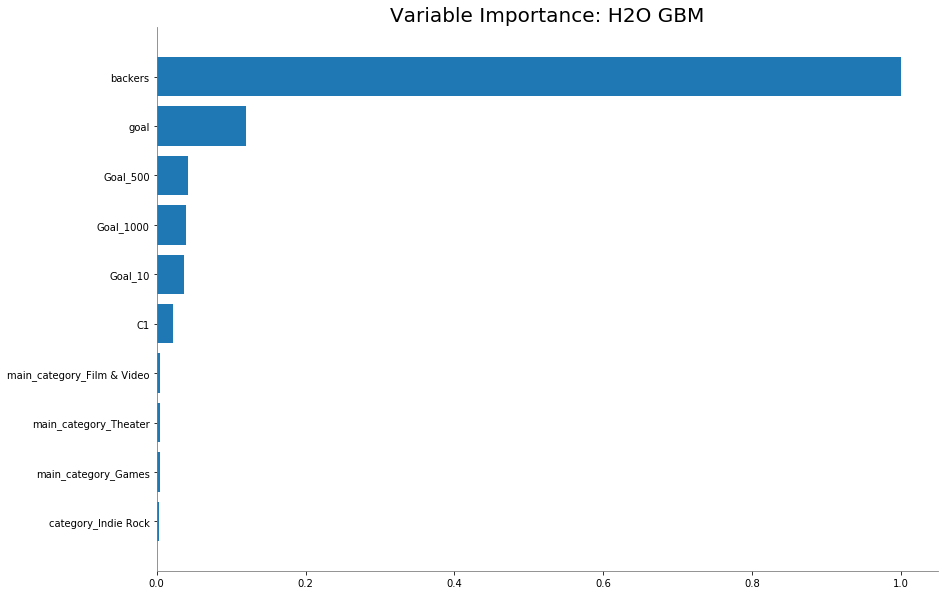

In [75]:
mod_best.varimp_plot()

In [79]:
aml.leader.partial_plot(data=df, cols=df.columns)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'C1'



c1,mean_response,stddev_response,std_error_mean_response
0.0,0.4007936,0.4311687,0.0064935
263.0526316,0.4168924,0.4327756,0.0065177
526.1052632,0.4134896,0.4298699,0.0064739
789.1578947,0.4071562,0.4308449,0.0064886
1052.2105263,0.4046407,0.4310404,0.0064915
1315.2631579,0.4032623,0.4318967,0.0065044
1578.3157895,0.4080253,0.4321004,0.0065075
1841.3684211,0.4134526,0.4336759,0.0065312
2104.4210526,0.4121184,0.4342665,0.0065401
2367.4736842,0.4076687,0.4343278,0.0065411


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'goal'



goal,mean_response,stddev_response,std_error_mean_response
0.6471032,0.6464877,0.3540335,0.0053318
1.4896165,0.6459818,0.3540944,0.0053327
2.3321297,0.6454450,0.3541680,0.0053338
3.1746429,0.6368347,0.3554539,0.0053532
4.0171562,0.6361503,0.3556361,0.0053559
4.8596694,0.6430238,0.3528711,0.0053143
5.7021827,0.5837184,0.3919581,0.0059030
6.5446959,0.5099964,0.4275152,0.0064385
7.3872091,0.4702202,0.4258936,0.0064140
8.2297224,0.4025370,0.4137315,0.0062309


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'backers'



backers,mean_response,stddev_response,std_error_mean_response
0.0,0.0056147,0.0347938,0.0005240
1940.1578947,1.0297996,0.0613595,0.0009241
3880.3157895,1.0345731,0.0606718,0.0009137
5820.4736842,1.0351715,0.0603985,0.0009096
7760.6315789,1.0348632,0.0603288,0.0009086
9700.7894737,1.0344870,0.0603166,0.0009084
11640.9473684,1.0341784,0.0602972,0.0009081
13581.1052632,1.0339148,0.0602646,0.0009076
15521.2631579,1.0336880,0.0602237,0.0009070
17461.4210526,1.0334930,0.0601917,0.0009065


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'country_is_us'



country_is_us,mean_response,stddev_response,std_error_mean_response
0.0,0.4025060,0.4234197,0.0063768
1.0,0.4110185,0.4310956,0.0064924


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'Goal_1000'



goal_1000,mean_response,stddev_response,std_error_mean_response
0.0,0.4165138,0.4321696,0.0065085
900.2105263,0.3724998,0.3859037,0.0058118
1800.4210526,0.3700047,0.3856298,0.0058077
2700.6315789,0.3679306,0.3853212,0.0058030
3600.8421053,0.3662204,0.3850250,0.0057985
4501.0526316,0.3647978,0.3848159,0.0057954
5401.2631579,0.3636705,0.3847030,0.0057937
6301.4736842,0.3626835,0.3846177,0.0057924
7201.6842105,0.3618067,0.3845484,0.0057914
8101.8947368,0.3609892,0.3844946,0.0057906


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'Goal_500'



goal_500,mean_response,stddev_response,std_error_mean_response
0.0,0.4247061,0.4283995,0.0064518
1800.4736842,0.3674327,0.3937524,0.0059300
3600.9473684,0.3662746,0.3933908,0.0059245
5401.4210526,0.3654852,0.3930711,0.0059197
7201.8947368,0.3649829,0.3927970,0.0059156
9002.3684211,0.3647170,0.3926015,0.0059126
10802.8421053,0.3646123,0.3924663,0.0059106
12603.3157895,0.3645342,0.3923475,0.0059088
14403.7894737,0.3644443,0.3922389,0.0059072
16204.2631579,0.3643489,0.3921346,0.0059056


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'Goal_10'



goal_10,mean_response,stddev_response,std_error_mean_response
0.0,0.4429492,0.4275076,0.0064383
90023.8947368,0.3413151,0.3712127,0.0055905
180047.7894737,0.3389403,0.3708384,0.0055849
270071.6842105,0.3371408,0.3705281,0.0055802
360095.5789474,0.3358864,0.3703546,0.0055776
450119.4736842,0.3349578,0.3702728,0.0055764
540143.3684211,0.3341501,0.3702321,0.0055758
630167.2631579,0.3334581,0.3702077,0.0055754
720191.1578947,0.3328493,0.3701883,0.0055751
810215.0526316,0.3322969,0.3701528,0.0055746


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Comics'



main_category_comics,mean_response,stddev_response,std_error_mean_response
0.0,0.4095013,0.4298511,0.0064736
1.0,0.3996534,0.4296550,0.0064707


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Crafts'



main_category_crafts,mean_response,stddev_response,std_error_mean_response
0.0,0.4092510,0.4298397,0.0064735
1.0,0.4058614,0.4288256,0.0064582


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Dance'



main_category_dance,mean_response,stddev_response,std_error_mean_response
0.0,0.4091198,0.4297275,0.0064718
1.0,0.4167513,0.4283654,0.0064513


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Design'



main_category_design,mean_response,stddev_response,std_error_mean_response
0.0,0.4105592,0.4305309,0.0064839
1.0,0.3910299,0.4163099,0.0062697


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Fashion'



main_category_fashion,mean_response,stddev_response,std_error_mean_response
0.0,0.4091748,0.4298266,0.0064733
1.0,0.4109915,0.4285856,0.0064546


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Film & Video'



main_category_film__video,mean_response,stddev_response,std_error_mean_response
0.0,0.4048037,0.4270892,0.0064320
1.0,0.4285686,0.4391167,0.0066132


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Food'



main_category_food,mean_response,stddev_response,std_error_mean_response
0.0,0.4097014,0.4301772,0.0064785
1.0,0.4005411,0.4201495,0.0063275


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Games'



main_category_games,mean_response,stddev_response,std_error_mean_response
0.0,0.4136877,0.4329023,0.0065196
1.0,0.3658190,0.3987280,0.0060049


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Journalism'



main_category_journalism,mean_response,stddev_response,std_error_mean_response
0.0,0.4092653,0.4297866,0.0064727
1.0,0.4052784,0.4291653,0.0064633


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Music'



main_category_music,mean_response,stddev_response,std_error_mean_response
0.0,0.4070522,0.4286277,0.0064552
1.0,0.4186476,0.4313299,0.0064959


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Photography'



main_category_photography,mean_response,stddev_response,std_error_mean_response
0.0,0.4092878,0.4298252,0.0064732
1.0,0.4071476,0.4286522,0.0064556


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Publishing'



main_category_publishing,mean_response,stddev_response,std_error_mean_response
0.0,0.4095602,0.4297874,0.0064727
1.0,0.4074758,0.4291580,0.0064632


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Technology'



main_category_technology,mean_response,stddev_response,std_error_mean_response
0.0,0.4093262,0.4297454,0.0064720
1.0,0.4052116,0.4273944,0.0064366


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'main_category_Theater'



main_category_theater,mean_response,stddev_response,std_error_mean_response
0.0,0.4085707,0.4299017,0.0064744
1.0,0.4283274,0.4163044,0.0062696


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Academic'



category_academic,mean_response,stddev_response,std_error_mean_response
0.0,0.4092340,0.4297951,0.0064728
1.0,0.4000592,0.4291677,0.0064633


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Accessories'



category_accessories,mean_response,stddev_response,std_error_mean_response
0.0,0.4092223,0.4297951,0.0064728
1.0,0.4085906,0.4291072,0.0064624


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Action'



category_action,mean_response,stddev_response,std_error_mean_response
0.0,0.4092269,0.4297922,0.0064727
1.0,0.4008166,0.4288805,0.0064590


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Animals'



category_animals,mean_response,stddev_response,std_error_mean_response
0.0,0.4092346,0.4298011,0.0064729
1.0,0.4009142,0.4285476,0.0064540


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Animation'



category_animation,mean_response,stddev_response,std_error_mean_response
0.0,0.4093034,0.4297738,0.0064725
1.0,0.4016643,0.4296881,0.0064712


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Anthologies'



category_anthologies,mean_response,stddev_response,std_error_mean_response
0.0,0.4092161,0.4297965,0.0064728
1.0,0.4115318,0.4290092,0.0064610


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Apparel'



category_apparel,mean_response,stddev_response,std_error_mean_response
0.0,0.4092625,0.4297675,0.0064724
1.0,0.4073793,0.4294127,0.0064670


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Apps'



category_apps,mean_response,stddev_response,std_error_mean_response
0.0,0.4092837,0.4297538,0.0064722
1.0,0.4050536,0.4286975,0.0064563


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Architecture'



category_architecture,mean_response,stddev_response,std_error_mean_response
0.0,0.4092195,0.4298007,0.0064729
1.0,0.4087948,0.4284962,0.0064532


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Art'



category_art,mean_response,stddev_response,std_error_mean_response
0.0,0.4091375,0.4298084,0.0064730
1.0,0.4121936,0.4269931,0.0064306


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Art Books'



category_art_books,mean_response,stddev_response,std_error_mean_response
0.0,0.4092488,0.4298010,0.0064729
1.0,0.4049674,0.4301659,0.0064784


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Audio'



category_audio,mean_response,stddev_response,std_error_mean_response
0.0,0.4092125,0.4298004,0.0064729
1.0,0.4152532,0.4290095,0.0064610


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Bacon'



category_bacon,mean_response,stddev_response,std_error_mean_response
0.0,0.4092285,0.4297920,0.0064727
1.0,0.3939113,0.4291021,0.0064624


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Blues'



category_blues,mean_response,stddev_response,std_error_mean_response
0.0,0.4092232,0.4297960,0.0064728
1.0,0.4037490,0.4289046,0.0064594


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Calendars'



category_calendars,mean_response,stddev_response,std_error_mean_response
0.0,0.4092190,0.4297955,0.0064728
1.0,0.4127326,0.4283471,0.0064510


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Camera Equipment'



category_camera_equipment,mean_response,stddev_response,std_error_mean_response
0.0,0.4092183,0.4297977,0.0064728
1.0,0.4105266,0.4292778,0.0064650


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Candles'



category_candles,mean_response,stddev_response,std_error_mean_response
0.0,0.4092235,0.4297970,0.0064728
1.0,0.4091680,0.4285468,0.0064540


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Ceramics'



category_ceramics,mean_response,stddev_response,std_error_mean_response
0.0,0.4092361,0.4297917,0.0064727
1.0,0.4008171,0.4282204,0.0064491


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Children's Books'



category_childrens_books,mean_response,stddev_response,std_error_mean_response
0.0,0.4092220,0.4297932,0.0064728
1.0,0.4087779,0.4293169,0.0064656


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Childrenswear'



category_childrenswear,mean_response,stddev_response,std_error_mean_response
0.0,0.4092250,0.4297926,0.0064728
1.0,0.4014162,0.4280688,0.0064468


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Civic Design'



category_civic_design,mean_response,stddev_response,std_error_mean_response
0.0,0.4092204,0.4297971,0.0064728
1.0,0.4092204,0.4297971,0.0064728


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Classical Music'



category_classical_music,mean_response,stddev_response,std_error_mean_response
0.0,0.4092191,0.4298062,0.0064730
1.0,0.4111680,0.4273584,0.0064361


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Comedy'



category_comedy,mean_response,stddev_response,std_error_mean_response
0.0,0.4092269,0.4297957,0.0064728
1.0,0.4073320,0.4296429,0.0064705


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Comic Books'



category_comic_books,mean_response,stddev_response,std_error_mean_response
0.0,0.4091771,0.4297654,0.0064723
1.0,0.4131483,0.4293838,0.0064666


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Comics'



category_comics,mean_response,stddev_response,std_error_mean_response
0.0,0.4096902,0.4302753,0.0064800
1.0,0.3941080,0.4195265,0.0063181


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Community Gardens'



category_community_gardens,mean_response,stddev_response,std_error_mean_response
0.0,0.4092259,0.4297920,0.0064727
1.0,0.4084716,0.4283205,0.0064506


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Conceptual Art'



category_conceptual_art,mean_response,stddev_response,std_error_mean_response
0.0,0.4092398,0.4297966,0.0064728
1.0,0.4031003,0.4284644,0.0064527


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Cookbooks'



category_cookbooks,mean_response,stddev_response,std_error_mean_response
0.0,0.4092307,0.4298046,0.0064729
1.0,0.4028634,0.4282023,0.0064488


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Country & Folk'



category_country__folk,mean_response,stddev_response,std_error_mean_response
0.0,0.4092108,0.4297919,0.0064727
1.0,0.4124092,0.4289122,0.0064595


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Crafts'



category_crafts,mean_response,stddev_response,std_error_mean_response
0.0,0.4093016,0.4297876,0.0064727
1.0,0.4043507,0.4296655,0.0064708


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Crochet'



category_crochet,mean_response,stddev_response,std_error_mean_response
0.0,0.4092223,0.4297954,0.0064728
1.0,0.4077877,0.4282276,0.0064492


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_DIY'



category_diy,mean_response,stddev_response,std_error_mean_response
0.0,0.4092597,0.4297818,0.0064726
1.0,0.4040172,0.4288458,0.0064585


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_DIY Electronics'



category_diy_electronics,mean_response,stddev_response,std_error_mean_response
0.0,0.4092144,0.4297946,0.0064728
1.0,0.4129791,0.4291219,0.0064626


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Dance'



category_dance,mean_response,stddev_response,std_error_mean_response
0.0,0.4091701,0.4297501,0.0064721
1.0,0.4162746,0.4287883,0.0064576


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Design'



category_design,mean_response,stddev_response,std_error_mean_response
0.0,0.4092274,0.4298132,0.0064731
1.0,0.4085654,0.4285784,0.0064545


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Digital Art'



category_digital_art,mean_response,stddev_response,std_error_mean_response
0.0,0.4092213,0.4297999,0.0064729
1.0,0.4101926,0.4293442,0.0064660


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Documentary'



category_documentary,mean_response,stddev_response,std_error_mean_response
0.0,0.4092439,0.4297846,0.0064726
1.0,0.4090157,0.4297872,0.0064727


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Drama'



category_drama,mean_response,stddev_response,std_error_mean_response
0.0,0.4092304,0.4297977,0.0064728
1.0,0.4069965,0.4288321,0.0064583


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Drinks'



category_drinks,mean_response,stddev_response,std_error_mean_response
0.0,0.4092256,0.4298077,0.0064730
1.0,0.4107408,0.4281726,0.0064484


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Electronic Music'



category_electronic_music,mean_response,stddev_response,std_error_mean_response
0.0,0.4092353,0.4297972,0.0064728
1.0,0.4095036,0.4291991,0.0064638


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Embroidery'



category_embroidery,mean_response,stddev_response,std_error_mean_response
0.0,0.4092225,0.4297951,0.0064728
1.0,0.4020085,0.4284647,0.0064528


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Events'



category_events,mean_response,stddev_response,std_error_mean_response
0.0,0.4092255,0.4297983,0.0064728
1.0,0.4087463,0.4286757,0.0064559


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Experimental'



category_experimental,mean_response,stddev_response,std_error_mean_response
0.0,0.4092277,0.4297967,0.0064728
1.0,0.4072256,0.4282511,0.0064495


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Fabrication Tools'



category_fabrication_tools,mean_response,stddev_response,std_error_mean_response
0.0,0.4092148,0.4297962,0.0064728
1.0,0.4120129,0.4292551,0.0064647


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Faith'



category_faith,mean_response,stddev_response,std_error_mean_response
0.0,0.4092490,0.4297831,0.0064726
1.0,0.4011285,0.4291061,0.0064624


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Family'



category_family,mean_response,stddev_response,std_error_mean_response
0.0,0.4092088,0.4297927,0.0064728
1.0,0.4205939,0.4282098,0.0064489


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Fantasy'



category_fantasy,mean_response,stddev_response,std_error_mean_response
0.0,0.4092222,0.4297956,0.0064728
1.0,0.4081052,0.4286794,0.0064560


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Farmer's Markets'



category_farmers_markets,mean_response,stddev_response,std_error_mean_response
0.0,0.4092196,0.4297971,0.0064728
1.0,0.4098430,0.4288120,0.0064580


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Farms'



category_farms,mean_response,stddev_response,std_error_mean_response
0.0,0.4092323,0.4297971,0.0064728
1.0,0.4043809,0.4291014,0.0064623


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Fashion'



category_fashion,mean_response,stddev_response,std_error_mean_response
0.0,0.4095192,0.4298078,0.0064730
1.0,0.3982806,0.4242265,0.0063889


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Festivals'



category_festivals,mean_response,stddev_response,std_error_mean_response
0.0,0.4092044,0.4297955,0.0064728
1.0,0.4162948,0.4286222,0.0064551


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Fiction'



category_fiction,mean_response,stddev_response,std_error_mean_response
0.0,0.4093192,0.4297603,0.0064723
1.0,0.4054823,0.4290031,0.0064609


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Film & Video'



category_film__video,mean_response,stddev_response,std_error_mean_response
0.0,0.4093378,0.4297620,0.0064723
1.0,0.4067109,0.4294927,0.0064682


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Fine Art'



category_fine_art,mean_response,stddev_response,std_error_mean_response
0.0,0.4092427,0.4297804,0.0064726
1.0,0.4021739,0.4286910,0.0064562


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Flight'



category_flight,mean_response,stddev_response,std_error_mean_response
0.0,0.4092279,0.4297944,0.0064728
1.0,0.4032237,0.4285901,0.0064546


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Food'



category_food,mean_response,stddev_response,std_error_mean_response
0.0,0.4097663,0.4298779,0.0064740
1.0,0.3905381,0.4193790,0.0063159


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Food Trucks'



category_food_trucks,mean_response,stddev_response,std_error_mean_response
0.0,0.4092363,0.4297892,0.0064727
1.0,0.4113764,0.4288227,0.0064581


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Footwear'



category_footwear,mean_response,stddev_response,std_error_mean_response
0.0,0.4092163,0.4297977,0.0064728
1.0,0.4129082,0.4290262,0.0064612


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Gadgets'



category_gadgets,mean_response,stddev_response,std_error_mean_response
0.0,0.4093004,0.4297759,0.0064725
1.0,0.3969288,0.4292276,0.0064642


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Games'



category_games,mean_response,stddev_response,std_error_mean_response
0.0,0.4092591,0.4297726,0.0064724
1.0,0.4063645,0.4288402,0.0064584


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Gaming Hardware'



category_gaming_hardware,mean_response,stddev_response,std_error_mean_response
0.0,0.4092273,0.4297970,0.0064728
1.0,0.3980348,0.4280658,0.0064467


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Glass'



category_glass,mean_response,stddev_response,std_error_mean_response
0.0,0.4092225,0.4297983,0.0064728
1.0,0.4019889,0.4287449,0.0064570


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Graphic Design'



category_graphic_design,mean_response,stddev_response,std_error_mean_response
0.0,0.4092209,0.4297982,0.0064728
1.0,0.4095290,0.4288914,0.0064592


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Graphic Novels'



category_graphic_novels,mean_response,stddev_response,std_error_mean_response
0.0,0.4091594,0.4297996,0.0064729
1.0,0.4258410,0.4279520,0.0064450


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Hardware'



category_hardware,mean_response,stddev_response,std_error_mean_response
0.0,0.4091582,0.4297888,0.0064727
1.0,0.4146650,0.4303855,0.0064817


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Hip-Hop'



category_hiphop,mean_response,stddev_response,std_error_mean_response
0.0,0.4093481,0.4297345,0.0064719
1.0,0.4027959,0.4283449,0.0064509


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Horror'



category_horror,mean_response,stddev_response,std_error_mean_response
0.0,0.4092431,0.4297842,0.0064726
1.0,0.4045936,0.4292732,0.0064649


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Illustration'



category_illustration,mean_response,stddev_response,std_error_mean_response
0.0,0.4092302,0.4297947,0.0064728
1.0,0.4066923,0.4294973,0.0064683


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Immersive'



category_immersive,mean_response,stddev_response,std_error_mean_response
0.0,0.4092224,0.4297965,0.0064728
1.0,0.4100441,0.4283218,0.0064506


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Indie Rock'



category_indie_rock,mean_response,stddev_response,std_error_mean_response
0.0,0.4090836,0.4297179,0.0064716
1.0,0.4188270,0.4268876,0.0064290


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Installations'



category_installations,mean_response,stddev_response,std_error_mean_response
0.0,0.4092272,0.4297970,0.0064728
1.0,0.4047916,0.4286137,0.0064550


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Interactive Design'



category_interactive_design,mean_response,stddev_response,std_error_mean_response
0.0,0.4092185,0.4297968,0.0064728
1.0,0.4110642,0.4286766,0.0064559


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Jazz'



category_jazz,mean_response,stddev_response,std_error_mean_response
0.0,0.4092263,0.4298026,0.0064729
1.0,0.4123195,0.4278774,0.0064439


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Jewelry'



category_jewelry,mean_response,stddev_response,std_error_mean_response
0.0,0.4092292,0.4297945,0.0064728
1.0,0.4062213,0.4290368,0.0064614


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Journalism'



category_journalism,mean_response,stddev_response,std_error_mean_response
0.0,0.4092149,0.4297982,0.0064728
1.0,0.4082359,0.4295873,0.0064697


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Kids'



category_kids,mean_response,stddev_response,std_error_mean_response
0.0,0.4092257,0.4297979,0.0064728
1.0,0.3998973,0.4290277,0.0064612


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Knitting'



category_knitting,mean_response,stddev_response,std_error_mean_response
0.0,0.4092186,0.4297963,0.0064728
1.0,0.4151112,0.4282722,0.0064499


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Latin'



category_latin,mean_response,stddev_response,std_error_mean_response
0.0,0.4092158,0.4297968,0.0064728
1.0,0.4218189,0.4284448,0.0064525


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Letterpress'



category_letterpress,mean_response,stddev_response,std_error_mean_response
0.0,0.4092151,0.4297955,0.0064728
1.0,0.4172351,0.4287361,0.0064568


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Literary Journals'



category_literary_journals,mean_response,stddev_response,std_error_mean_response
0.0,0.4092201,0.4297974,0.0064728
1.0,0.4083348,0.4287613,0.0064572


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Live Games'



category_live_games,mean_response,stddev_response,std_error_mean_response
0.0,0.4092272,0.4297918,0.0064727
1.0,0.4088470,0.4295190,0.0064686


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Makerspaces'



category_makerspaces,mean_response,stddev_response,std_error_mean_response
0.0,0.4092209,0.4297966,0.0064728
1.0,0.4074643,0.4289031,0.0064594


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Metal'



category_metal,mean_response,stddev_response,std_error_mean_response
0.0,0.4092218,0.4297988,0.0064728
1.0,0.4115193,0.4288163,0.0064580


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Mixed Media'



category_mixed_media,mean_response,stddev_response,std_error_mean_response
0.0,0.4092253,0.4298001,0.0064729
1.0,0.4090595,0.4289623,0.0064602


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Mobile Games'



category_mobile_games,mean_response,stddev_response,std_error_mean_response
0.0,0.4092418,0.4297825,0.0064726
1.0,0.4055599,0.4290541,0.0064616


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Movie Theaters'



category_movie_theaters,mean_response,stddev_response,std_error_mean_response
0.0,0.4092225,0.4297983,0.0064728
1.0,0.4096945,0.4285236,0.0064536


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Music'



category_music,mean_response,stddev_response,std_error_mean_response
0.0,0.4092100,0.4297839,0.0064726
1.0,0.4100822,0.4297474,0.0064721


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Music Videos'



category_music_videos,mean_response,stddev_response,std_error_mean_response
0.0,0.4092210,0.4297970,0.0064728
1.0,0.4092164,0.4290732,0.0064619


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Musical'



category_musical,mean_response,stddev_response,std_error_mean_response
0.0,0.4092245,0.4297957,0.0064728
1.0,0.4103555,0.4292068,0.0064639


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Narrative Film'



category_narrative_film,mean_response,stddev_response,std_error_mean_response
0.0,0.4091653,0.4298650,0.0064738
1.0,0.4130532,0.4251379,0.0064026


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Nature'



category_nature,mean_response,stddev_response,std_error_mean_response
0.0,0.4092208,0.4297971,0.0064728
1.0,0.4125538,0.4282970,0.0064502


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Nonfiction'



category_nonfiction,mean_response,stddev_response,std_error_mean_response
0.0,0.4092649,0.4297987,0.0064728
1.0,0.4082684,0.4287262,0.0064567


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Painting'



category_painting,mean_response,stddev_response,std_error_mean_response
0.0,0.4092479,0.4297903,0.0064727
1.0,0.4093273,0.4287894,0.0064576


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_People'



category_people,mean_response,stddev_response,std_error_mean_response
0.0,0.4092305,0.4297937,0.0064728
1.0,0.4105882,0.4282363,0.0064493


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Performance Art'



category_performance_art,mean_response,stddev_response,std_error_mean_response
0.0,0.4092336,0.4297999,0.0064729
1.0,0.4083434,0.4292490,0.0064646


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Performances'



category_performances,mean_response,stddev_response,std_error_mean_response
0.0,0.4092193,0.4297968,0.0064728
1.0,0.4114206,0.4290024,0.0064609


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Periodicals'



category_periodicals,mean_response,stddev_response,std_error_mean_response
0.0,0.4092295,0.4297956,0.0064728
1.0,0.4040026,0.4292371,0.0064644


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Pet Fashion'



category_pet_fashion,mean_response,stddev_response,std_error_mean_response
0.0,0.4092225,0.4297959,0.0064728
1.0,0.4038715,0.4283370,0.0064508


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Photo'



category_photo,mean_response,stddev_response,std_error_mean_response
0.0,0.4092215,0.4297962,0.0064728
1.0,0.4053362,0.4293280,0.0064658


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Photobooks'



category_photobooks,mean_response,stddev_response,std_error_mean_response
0.0,0.4092558,0.4297998,0.0064729
1.0,0.4054679,0.4288628,0.0064587


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Photography'



category_photography,mean_response,stddev_response,std_error_mean_response
0.0,0.4094010,0.4297947,0.0064728
1.0,0.4031083,0.4286645,0.0064558


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Places'



category_places,mean_response,stddev_response,std_error_mean_response
0.0,0.4092264,0.4297969,0.0064728
1.0,0.4082203,0.4284782,0.0064530


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Playing Cards'



category_playing_cards,mean_response,stddev_response,std_error_mean_response
0.0,0.4091962,0.4297850,0.0064726
1.0,0.4128582,0.4290280,0.0064612


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Plays'



category_plays,mean_response,stddev_response,std_error_mean_response
0.0,0.4091974,0.4297810,0.0064726
1.0,0.4129217,0.4289974,0.0064608


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Poetry'



category_poetry,mean_response,stddev_response,std_error_mean_response
0.0,0.4092555,0.4297913,0.0064727
1.0,0.4000671,0.4289468,0.0064600


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Pop'



category_pop,mean_response,stddev_response,std_error_mean_response
0.0,0.4092640,0.4298039,0.0064729
1.0,0.4078507,0.4288158,0.0064580


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Pottery'



category_pottery,mean_response,stddev_response,std_error_mean_response
0.0,0.4092211,0.4297966,0.0064728
1.0,0.4081762,0.4287704,0.0064574


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Print'



category_print,mean_response,stddev_response,std_error_mean_response
0.0,0.4092119,0.4297963,0.0064728
1.0,0.4187486,0.4290775,0.0064620


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Printing'



category_printing,mean_response,stddev_response,std_error_mean_response
0.0,0.4092210,0.4297966,0.0064728
1.0,0.4146332,0.4274777,0.0064379


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Product Design'



category_product_design,mean_response,stddev_response,std_error_mean_response
0.0,0.4110999,0.4308943,0.0064893
1.0,0.3830114,0.4121628,0.0062072


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Public Art'



category_public_art,mean_response,stddev_response,std_error_mean_response
0.0,0.4092410,0.4298497,0.0064736
1.0,0.4088204,0.4253093,0.0064052


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Publishing'



category_publishing,mean_response,stddev_response,std_error_mean_response
0.0,0.4092419,0.4297934,0.0064728
1.0,0.4081911,0.4293257,0.0064657


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Punk'



category_punk,mean_response,stddev_response,std_error_mean_response
0.0,0.4092250,0.4297930,0.0064728
1.0,0.4015098,0.4290357,0.0064614


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Puzzles'



category_puzzles,mean_response,stddev_response,std_error_mean_response
0.0,0.4092301,0.4298014,0.0064729
1.0,0.3965737,0.4284968,0.0064532


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_R&B'



category_rb,mean_response,stddev_response,std_error_mean_response
0.0,0.4092425,0.4297876,0.0064727
1.0,0.4009680,0.4281568,0.0064481


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Radio & Podcasts'



category_radio__podcasts,mean_response,stddev_response,std_error_mean_response
0.0,0.4092241,0.4297968,0.0064728
1.0,0.4042895,0.4296668,0.0064709


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Ready-to-wear'



category_readytowear,mean_response,stddev_response,std_error_mean_response
0.0,0.4092157,0.4297996,0.0064729
1.0,0.4131957,0.4283802,0.0064515


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Restaurants'



category_restaurants,mean_response,stddev_response,std_error_mean_response
0.0,0.4091139,0.4298354,0.0064734
1.0,0.4245052,0.4267420,0.0064268


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Robots'



category_robots,mean_response,stddev_response,std_error_mean_response
0.0,0.4092078,0.4298017,0.0064729
1.0,0.4140872,0.4291987,0.0064638


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Rock'



category_rock,mean_response,stddev_response,std_error_mean_response
0.0,0.4091945,0.4298178,0.0064731
1.0,0.4122087,0.4281000,0.0064473


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Romance'



category_romance,mean_response,stddev_response,std_error_mean_response
0.0,0.4092215,0.4297961,0.0064728
1.0,0.4038169,0.4286618,0.0064557


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Science Fiction'



category_science_fiction,mean_response,stddev_response,std_error_mean_response
0.0,0.4092125,0.4297964,0.0064728
1.0,0.4124289,0.4293345,0.0064659


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Sculpture'



category_sculpture,mean_response,stddev_response,std_error_mean_response
0.0,0.4092601,0.4297793,0.0064725
1.0,0.4050527,0.4293442,0.0064660


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Shorts'



category_shorts,mean_response,stddev_response,std_error_mean_response
0.0,0.4085815,0.4296932,0.0064713
1.0,0.4266770,0.4239358,0.0063845


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Small Batch'



category_small_batch,mean_response,stddev_response,std_error_mean_response
0.0,0.4092178,0.4297992,0.0064729
1.0,0.4136202,0.4282285,0.0064492


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Software'



category_software,mean_response,stddev_response,std_error_mean_response
0.0,0.4093481,0.4297480,0.0064721
1.0,0.3940327,0.4268287,0.0064281


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Sound'



category_sound,mean_response,stddev_response,std_error_mean_response
0.0,0.4092240,0.4297971,0.0064728
1.0,0.4079913,0.4288844,0.0064591


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Space Exploration'



category_space_exploration,mean_response,stddev_response,std_error_mean_response
0.0,0.4092170,0.4297985,0.0064728
1.0,0.4142775,0.4281084,0.0064474


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Spaces'



category_spaces,mean_response,stddev_response,std_error_mean_response
0.0,0.4092353,0.4297903,0.0064727
1.0,0.4035632,0.4282169,0.0064490


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Stationery'



category_stationery,mean_response,stddev_response,std_error_mean_response
0.0,0.4092211,0.4297975,0.0064728
1.0,0.4119929,0.4285314,0.0064538


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Tabletop Games'



category_tabletop_games,mean_response,stddev_response,std_error_mean_response
0.0,0.4095948,0.4301066,0.0064775
1.0,0.4021414,0.4233296,0.0063754


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Technology'



category_technology,mean_response,stddev_response,std_error_mean_response
0.0,0.4092222,0.4297936,0.0064728
1.0,0.4095136,0.4294414,0.0064675


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Television'



category_television,mean_response,stddev_response,std_error_mean_response
0.0,0.4092190,0.4297983,0.0064728
1.0,0.4100796,0.4291170,0.0064626


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Textiles'



category_textiles,mean_response,stddev_response,std_error_mean_response
0.0,0.4092223,0.4297953,0.0064728
1.0,0.4039590,0.4281890,0.0064486


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Theater'



category_theater,mean_response,stddev_response,std_error_mean_response
0.0,0.4091725,0.4296990,0.0064713
1.0,0.4118407,0.4286876,0.0064561


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Thrillers'



category_thrillers,mean_response,stddev_response,std_error_mean_response
0.0,0.4092157,0.4297965,0.0064728
1.0,0.4117880,0.4290061,0.0064609


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Translations'



category_translations,mean_response,stddev_response,std_error_mean_response
0.0,0.4092199,0.4297965,0.0064728
1.0,0.4119496,0.4274512,0.0064375


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Typography'



category_typography,mean_response,stddev_response,std_error_mean_response
0.0,0.4092252,0.4297988,0.0064728
1.0,0.4034884,0.4287645,0.0064573


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Vegan'



category_vegan,mean_response,stddev_response,std_error_mean_response
0.0,0.4092461,0.4297947,0.0064728
1.0,0.4048646,0.4295604,0.0064693


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Video'



category_video,mean_response,stddev_response,std_error_mean_response
0.0,0.4092248,0.4297948,0.0064728
1.0,0.4039817,0.4294001,0.0064668


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Video Art'



category_video_art,mean_response,stddev_response,std_error_mean_response
0.0,0.4092237,0.4297975,0.0064728
1.0,0.4018927,0.4283765,0.0064514


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Video Games'



category_video_games,mean_response,stddev_response,std_error_mean_response
0.0,0.4096431,0.4300090,0.0064760
1.0,0.4016568,0.4238192,0.0063828


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Wearables'



category_wearables,mean_response,stddev_response,std_error_mean_response
0.0,0.4092038,0.4298020,0.0064729
1.0,0.4128242,0.4287405,0.0064569


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Weaving'



category_weaving,mean_response,stddev_response,std_error_mean_response
0.0,0.4092271,0.4297918,0.0064727
1.0,0.4046567,0.4286435,0.0064554


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Web'



category_web,mean_response,stddev_response,std_error_mean_response
0.0,0.4092941,0.4297350,0.0064719
1.0,0.4034985,0.4291647,0.0064633


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Webcomics'



category_webcomics,mean_response,stddev_response,std_error_mean_response
0.0,0.4092120,0.4297937,0.0064728
1.0,0.4148255,0.4286602,0.0064557


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Webseries'



category_webseries,mean_response,stddev_response,std_error_mean_response
0.0,0.4092529,0.4298587,0.0064737
1.0,0.4080062,0.4275850,0.0064395


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Woodworking'



category_woodworking,mean_response,stddev_response,std_error_mean_response
0.0,0.4092224,0.4297965,0.0064728
1.0,0.4117958,0.4280645,0.0064467


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Workshops'



category_workshops,mean_response,stddev_response,std_error_mean_response
0.0,0.4092274,0.4297948,0.0064728
1.0,0.4038176,0.4284284,0.0064522


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_World Music'



category_world_music,mean_response,stddev_response,std_error_mean_response
0.0,0.4092577,0.4297976,0.0064728
1.0,0.4062037,0.4294548,0.0064677


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Young Adult'



category_young_adult,mean_response,stddev_response,std_error_mean_response
0.0,0.4092322,0.4297904,0.0064727
1.0,0.4042980,0.4293013,0.0064654


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'category_Zines'



category_zines,mean_response,stddev_response,std_error_mean_response
0.0,0.4092211,0.4297976,0.0064728
1.0,0.4075098,0.4287437,0.0064570


PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_0_AutoML_20181030_234033 on column 'state'



state,mean_response,stddev_response,std_error_mean_response
0.0,0.4092204,0.4297971,0.0064728
1.0,0.4092204,0.4297971,0.0064728


[,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ,
 ]

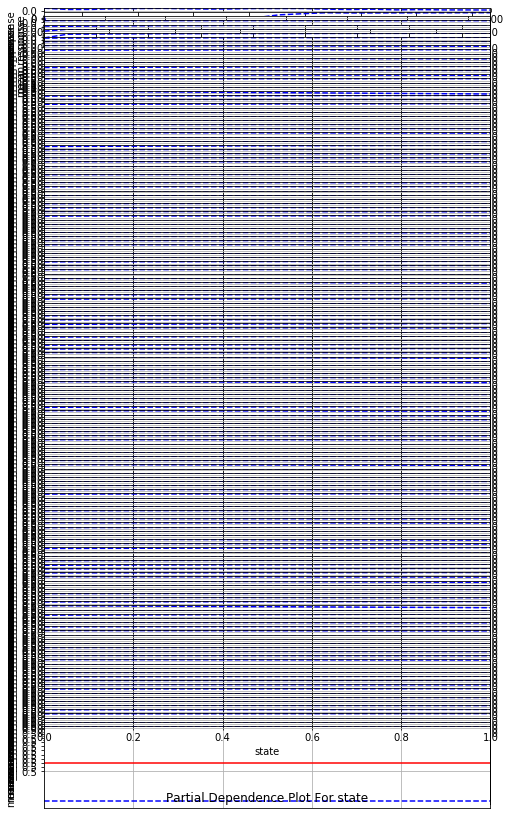

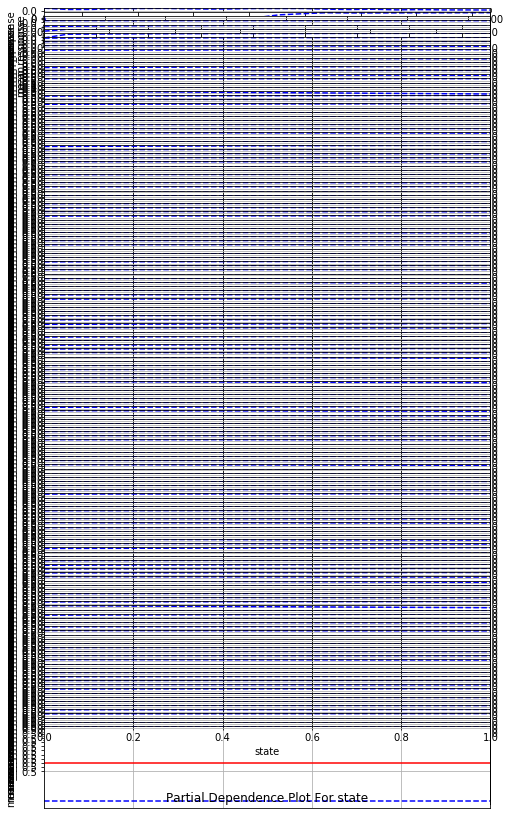

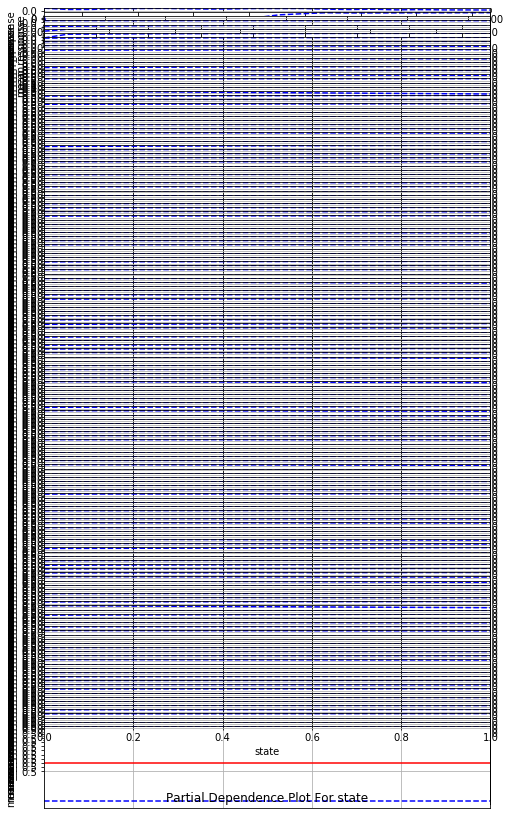

In [82]:
import matplotlib.pyplot as plt
plt.show()

In [ ]:
# Clean up
os.chdir(server_path)

In [ ]:
h2o.cluster().shutdown()